# GSM4949911 TEAseq spectral clustering and SCML analysis

In [1]:
from sc_spectrum.scml import rbf_neighbor_graph
from sc_spectrum.scml import sparse_spectral
from sc_spectrum.scml import scml
from sc_spectrum.scml import spectral_clustering
from sc_spectrum.scml import soft_scml

from sc_spectrum.visualization import umap_embed, umap_scatter, recolor_clusters

/home/groups/song/songlab2/jacobrl3/sc-spectrum/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from time import asctime, localtime

import numpy as np
import pandas as pd

import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import torch

from typing import Tuple
from typing import List

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import seaborn as sns

plt.style.use('default')
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

In [3]:
use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Read processed files from Seurat

In [4]:
input_dir = "../../sc-spectrum-datasets/"

In [5]:
GSM4949911_rna_pca = pd.read_csv(input_dir + "seurat_wnn_TEAseq_reduc_pca.csv", header = 0, index_col = 0).iloc[:,:30]
GSM4949911_adt_pca = pd.read_csv(input_dir + "seurat_wnn_TEAseq_reduc_adt_pca.csv", header = 0, index_col = 0).iloc[:,:30]
GSM4949911_atac_lsi = pd.read_csv(input_dir + "seurat_wnn_TEAseq_reduc_atac_lsi.csv", header = 0, index_col = 0).iloc[:,:30]

In [6]:
print(GSM4949911_rna_pca.shape)
print(GSM4949911_adt_pca.shape)
print(GSM4949911_atac_lsi.shape)

(7550, 30)
(7550, 30)
(7550, 30)


In [7]:
n_clust = 12

### Make modality adjacency matrices

In [8]:
Gs_rna = rbf_neighbor_graph(GSM4949911_rna_pca.values.astype(np.float32), adaptive = True)

L_rna, w_rna, v_rna = sparse_spectral(Gs_rna, n_clust = n_clust)

cl_rna = spectral_clustering(v_rna, n_clust = n_clust)

In [9]:
Gs_adt = rbf_neighbor_graph(GSM4949911_adt_pca.values.astype(np.float32), adaptive = True)

L_adt, w_adt, v_adt = sparse_spectral(Gs_adt, n_clust = n_clust)

cl_adt = spectral_clustering(v_adt, n_clust = n_clust)

In [10]:
Gs_atac = rbf_neighbor_graph(GSM4949911_atac_lsi.values.astype(np.float32), adaptive = True)

L_atac, w_atac, v_atac = sparse_spectral(Gs_atac, n_clust = n_clust)

cl_atac = spectral_clustering(v_atac, n_clust = n_clust)

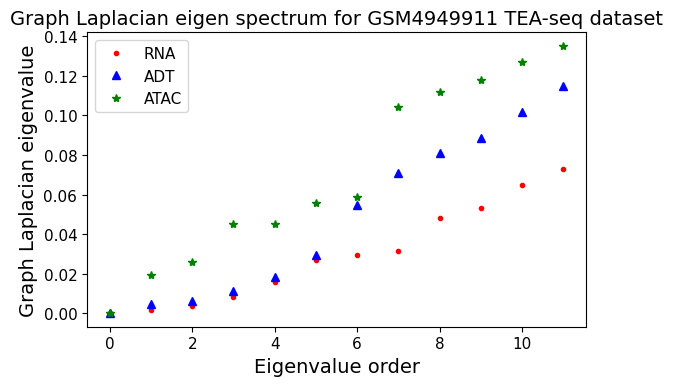

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

l1, = plt.plot(w_rna, 'r.')
l2, = plt.plot(w_adt, 'b^')
l3, = plt.plot(w_atac, 'g*')

ax.legend(handles=[l1, l2, l3], labels=["RNA", "ADT", "ATAC"])
ax.set_xlabel("Eigenvalue order", fontsize=14)
ax.set_ylabel("Graph Laplacian eigenvalue", fontsize=14)

ax.set_title("Graph Laplacian eigen spectrum for GSM4949911 TEA-seq dataset", fontsize=14)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/TEAseq-graph-Laplacian-spectra.pdf", format="pdf", transparent=True)

### SCML clustering

In [12]:
print("Start: {}".format(asctime(localtime())))
w_scml, v_scml, cl_scml = scml([Gs_rna, Gs_adt, Gs_atac], n_clust=n_clust, device=device, alpha=1.0)
print("End: {}".format(asctime(localtime())))

Start: Fri May 20 15:07:41 2022
End: Fri May 20 15:07:50 2022


### 2D UMAP embedding of SCML embedding

In [13]:
v_scml_norm = v_scml[:, :n_clust] / np.linalg.norm(v_scml[:, :n_clust], axis = 1, keepdims = True)

embedding = umap_embed(v_scml_norm, n_clust)

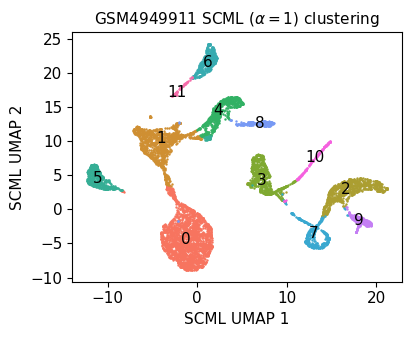

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, pd.DataFrame(embedding, index=GSM4949911_rna_pca.index, columns=["UMAP 1", "UMAP 2"]),
             cl_scml, show_labels = True, legend = False)

ax.set_xlabel("SCML UMAP 1", fontsize=11)
ax.set_ylabel("SCML UMAP 2", fontsize=11)
ax.set_title(r"GSM4949911 SCML $(\alpha = 1)$ clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/TEAseq-scml-clust-scml-umap.pdf", format="pdf", transparent=True)

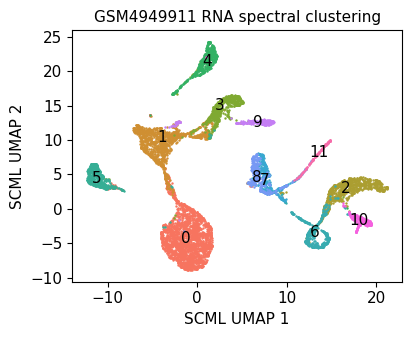

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, pd.DataFrame(embedding, index=GSM4949911_rna_pca.index, columns=["UMAP 1", "UMAP 2"]),
             cl_rna, show_labels = True, legend = False)

ax.set_xlabel("SCML UMAP 1", fontsize=11)
ax.set_ylabel("SCML UMAP 2", fontsize=11)
ax.set_title("GSM4949911 RNA spectral clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/TEAseq-rna-clust-scml-umap.pdf", format="pdf", transparent=True)

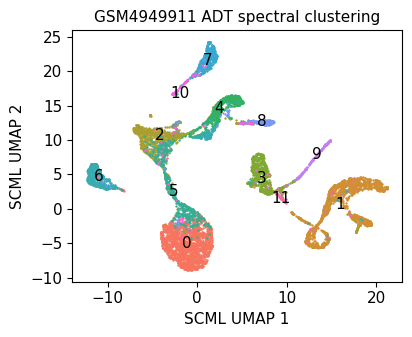

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, pd.DataFrame(embedding, index=GSM4949911_rna_pca.index, columns=["UMAP 1", "UMAP 2"]),
             cl_adt, show_labels = True, legend = False)

ax.set_xlabel("SCML UMAP 1", fontsize=11)
ax.set_ylabel("SCML UMAP 2", fontsize=11)
ax.set_title("GSM4949911 ADT spectral clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/TEAseq-adt-clust-scml-umap.pdf", format="pdf", transparent=True)

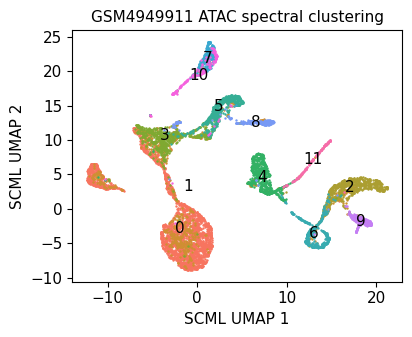

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, pd.DataFrame(embedding, index=GSM4949911_rna_pca.index, columns=["UMAP 1", "UMAP 2"]),
             cl_atac, show_labels = True, legend = False)

ax.set_xlabel("SCML UMAP 1", fontsize=11)
ax.set_ylabel("SCML UMAP 2", fontsize=11)
ax.set_title("GSM4949911 ATAC spectral clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/TEAseq-atac-clust-scml-umap.pdf", format="pdf", transparent=True)

### NMI table

In [18]:
clust_alg = ["RNA", "ADT", "ATAC", "SCML"]
clust_result = [cl_rna, cl_adt, cl_atac, cl_scml]

for i, alg in enumerate(clust_alg):
    print(alg + " & {:.3f} & {:.3f} & {:.3f} & {:.3f} \\\\".format(normalized_mutual_info_score(clust_result[i], clust_result[0]),
                                                        normalized_mutual_info_score(clust_result[i], clust_result[1]),
                                                        normalized_mutual_info_score(clust_result[i], clust_result[2]),
                                                        normalized_mutual_info_score(clust_result[i], clust_result[3])))


RNA & 1.000 & 0.689 & 0.645 & 0.851 \\
ADT & 0.689 & 1.000 & 0.549 & 0.771 \\
ATAC & 0.645 & 0.549 & 1.000 & 0.679 \\
SCML & 0.851 & 0.771 & 0.679 & 1.000 \\
